In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os



import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox



from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# This one is only available in the development verison of statsmodels
# Run:
#    pip install git+https://github.com/statsmodels/statsmodels.git
# to install the development version.
from statsmodels.tsa.statespace.sarimax import SARIMAX


# grid search sarima hyperparameters
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_score

from sklearn.linear_model import LinearRegression


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.ensemble import AdaBoostRegressor

from sklearn.tree import DecisionTreeRegressor


from scipy import signal
from scipy import stats

sys.path.append("..")
from eda_utilities import print_eda_stats
from data_pipeline import dockless_data_pipeline
from data_pipeline import weather_data_pipeline

In [32]:
data_014706 = pd.read_pickle("../../data/pickled_data/merged_data_014706_hourly.pkl")
weather_data = pd.read_pickle("../../data/pickled_data/weather_data.pkl")
weather_data.set_index('DATE')
weather_data = weather_data.drop(['level_0', 'index'], axis=1)

In [3]:
data_014706.head(5)

,014706,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,DATE,level_0,index,AVG_DAILY_WIND_SPEED,PRECIPITATION,SNOW,AVG_TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE
Start Time,,,,,,,,,,,,,,,,,,
2018-07-15 00:00:00,1,7,2018,0,15,28,6,1.0,0.0,2018-07-15,102,195,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 01:00:00,0,7,2018,1,15,28,6,1.0,0.0,2018-07-15,102,195,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 02:00:00,0,7,2018,2,15,28,6,1.0,0.0,2018-07-15,102,195,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 03:00:00,0,7,2018,3,15,28,6,1.0,0.0,2018-07-15,102,195,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 04:00:00,0,7,2018,4,15,28,6,1.0,0.0,2018-07-15,102,195,10.29,0.0,0.0,86.0,98.0,75.0


In [33]:
data_014706_2 = data_014706
data_014706_2 = data_014706_2.drop(['MONTH', 'YEAR', 'HOUR', 'DAY', 'WEEK', 'DAY_OF_WEEK',
       'WEEKEND', 'WEEKDAY', 'DATE', 'level_0', 'index',
       'AVG_DAILY_WIND_SPEED', 'PRECIPITATION', 'SNOW', 'AVG_TEMPERATURE',
       'MAX_TEMPERATURE', 'MIN_TEMPERATURE'], axis=1)
data_014706_2_hour = data_014706_2.resample('H', how='sum')
data_014706_2_hour = data_014706_2_hour.fillna(0)
data_014706_2_hour.head(5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  


,014706
Start Time,
2018-07-15 00:00:00,1
2018-07-15 01:00:00,0
2018-07-15 02:00:00,0
2018-07-15 03:00:00,0
2018-07-15 04:00:00,0


In [34]:
# Do the resampling before you add all the features

data_014706_2_hour['MONTH'] = pd.DatetimeIndex(data_014706_2_hour.index).month
data_014706_2_hour['YEAR'] = pd.DatetimeIndex(data_014706_2_hour.index).year
data_014706_2_hour['HOUR'] = pd.DatetimeIndex(data_014706_2_hour.index).hour
data_014706_2_hour['DAY'] = pd.DatetimeIndex(data_014706_2_hour.index).day
data_014706_2_hour['WEEK'] = pd.DatetimeIndex(data_014706_2_hour.index).week
data_014706_2_hour['DAY_OF_WEEK'] = pd.DatetimeIndex(data_014706_2_hour.index).weekday
data_014706_2_hour['WEEKEND'] = ((pd.DatetimeIndex(data_014706_2_hour.index).weekday) // 5 == 1).astype(float)
data_014706_2_hour['WEEKDAY'] = ((pd.DatetimeIndex(data_014706_2_hour.index).weekday) // 5 == 0).astype(float)
data_014706_2_hour['DATE'] = pd.DatetimeIndex(data_014706_2_hour.index).date
data_014706_2_hour.head(5)

,014706,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,DATE
Start Time,,,,,,,,,,
2018-07-15 00:00:00,1,7,2018,0,15,28,6,1.0,0.0,2018-07-15
2018-07-15 01:00:00,0,7,2018,1,15,28,6,1.0,0.0,2018-07-15
2018-07-15 02:00:00,0,7,2018,2,15,28,6,1.0,0.0,2018-07-15
2018-07-15 03:00:00,0,7,2018,3,15,28,6,1.0,0.0,2018-07-15
2018-07-15 04:00:00,0,7,2018,4,15,28,6,1.0,0.0,2018-07-15


In [35]:
# Add Weather Data 
data_014706_2_hour = data_014706_2_hour.reset_index().merge(weather_data, on='DATE', how="left").set_index('Start Time')
data_014706_2_hour.head(5)

# Drop DATE, level_0, index columns
#data_014706_2_hour = data_014706_2_hour.drop(['DATE', 'index', 'level_0'], axis=1)



,014706,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,DATE,AVG_DAILY_WIND_SPEED,PRECIPITATION,SNOW,AVG_TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE
Start Time,,,,,,,,,,,,,,,,
2018-07-15 00:00:00,1,7,2018,0,15,28,6,1.0,0.0,2018-07-15,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 01:00:00,0,7,2018,1,15,28,6,1.0,0.0,2018-07-15,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 02:00:00,0,7,2018,2,15,28,6,1.0,0.0,2018-07-15,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 03:00:00,0,7,2018,3,15,28,6,1.0,0.0,2018-07-15,10.29,0.0,0.0,86.0,98.0,75.0
2018-07-15 04:00:00,0,7,2018,4,15,28,6,1.0,0.0,2018-07-15,10.29,0.0,0.0,86.0,98.0,75.0


In [36]:
data_014706_2_hour = data_014706_2_hour.drop(['DATE'], axis=1)

In [72]:
#data_014706_2_hour_p = pd.merge(left=data_014706_2_hour,right=weather_data, how='left',left_on='DATE', right_on='DATE')
#merged_data_014706_hourly = data_014706_hourly.reset_index().merge(weather_data, on='DATE', how="left").set_index('Start Time')


In [37]:
data_014706_2_hour.columns

Index(['014706', 'MONTH', 'YEAR', 'HOUR', 'DAY', 'WEEK', 'DAY_OF_WEEK',
       'WEEKEND', 'WEEKDAY', 'AVG_DAILY_WIND_SPEED', 'PRECIPITATION', 'SNOW',
       'AVG_TEMPERATURE', 'MAX_TEMPERATURE', 'MIN_TEMPERATURE'],
      dtype='object')

In [47]:
# Create the test train split the same way as the univariate time series so this is the same as ARIMA series
size = int(len(data_014706_2_hour) * 0.66)
train, test = data_014706_2_hour[0:size], data_014706_2_hour[size:len(data_014706_2_hour)]
# train = train.drop([ 'index', 'level_0'], axis=1)
# test = test.drop([ 'index','level_0'], axis=1)
# train.pop('DATE')
# train.pop('index')
# test.pop('DATE')
# test.pop('index')

In [48]:
y_train = train.pop('014706').values
X_train = train.values
y_test = test.pop('014706').values
X_test = test.values


In [49]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    score = model.score(test_features, test_labels)
    print('Model Performance')
    print("Mean Square Error:", mean_squared_error(test_labels, predictions))
    print("Mean Absoulute Error:", mean_absolute_error(test_labels, predictions))
    print("Score:", score)
    return score

In [50]:
best_rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
           max_features=7, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=12, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

best_rf.fit(X_train, y_train)
best_random_forest_accuracy = evaluate(best_rf, X_test, y_test)

Model Performance
Mean Square Error: 9.790583648697464
Mean Absoulute Error: 1.7474866709825287
Score: 0.41633119498586313


In [51]:
best_rf_predictions = best_rf.predict(X_test)

In [52]:
train.head(5)

,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,AVG_DAILY_WIND_SPEED,PRECIPITATION,SNOW,AVG_TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE,HOUR_label
Start Time,,,,,,,,,,,,,,,
2018-07-15 00:00:00,7,2018,0,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 01:00:00,7,2018,1,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 02:00:00,7,2018,2,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 03:00:00,7,2018,3,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0
2018-07-15 04:00:00,7,2018,4,15,28,6,1.0,0.0,10.29,0.0,0.0,86.0,98.0,75.0,0


In [53]:
for i,j in  zip(train.columns.tolist(), best_rf.feature_importances_):
    print(i, ":", j)

MONTH : 0.016333019283797587
YEAR : 0.0
HOUR : 0.41499837387831723
DAY : 0.037937978349009575
WEEK : 0.036726663368865306
DAY_OF_WEEK : 0.05973083918556861
WEEKEND : 0.005920565097914403
WEEKDAY : 0.010740508187474346
AVG_DAILY_WIND_SPEED : 0.030723857576177228
PRECIPITATION : 0.026194306510842997
SNOW : 0.0
AVG_TEMPERATURE : 0.0287212968516416
MAX_TEMPERATURE : 0.038041386377396444
MIN_TEMPERATURE : 0.02456326118561861
HOUR_label : 0.26936794414737597


In [54]:
size = int(len(data_014706_2_hour) * 0.66)
train_1, test_1 = data_014706_2_hour[0:size], data_014706_2_hour[size:len(data_014706_2_hour)]

In [55]:
test_results = test_1.drop(['MONTH', 'YEAR', 'HOUR', 'DAY', 'WEEK', 'DAY_OF_WEEK',
       'WEEKEND', 'WEEKDAY',
       'AVG_DAILY_WIND_SPEED', 'PRECIPITATION', 'SNOW', 'AVG_TEMPERATURE',
       'MAX_TEMPERATURE', 'MIN_TEMPERATURE'], axis=1)
test_results.rename(columns=dict(zip(["014706"], ["Actual"])), inplace=True)
rf_list = best_rf_predictions.tolist()
test_results['rf_predictions'] = rf_list

In [56]:
test_results.head(5)

,Actual,HOUR_label,rf_predictions
Start Time,,,
2018-11-13 09:00:00,0,1,0.586052
2018-11-13 10:00:00,0,1,1.510995
2018-11-13 11:00:00,0,2,2.098963
2018-11-13 12:00:00,2,2,2.398503
2018-11-13 13:00:00,0,2,2.548376


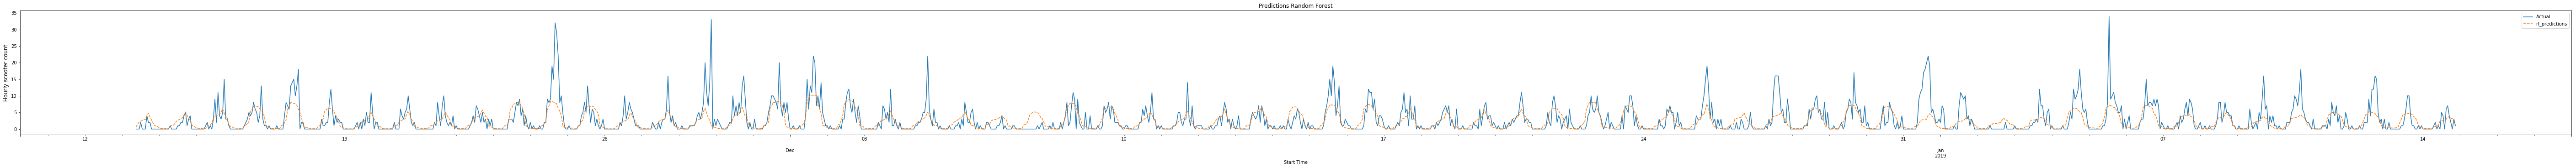

In [57]:
test_results.plot(style=['-', '--', ':'],figsize=(100, 5))
plt.title('Predictions Random Forest')
plt.ylabel('Hourly scooter count', fontsize=12)
plt.savefig('../../output/Random_Forest_Predictions_Commuter_Ho.png')

In [27]:
def groupbyCommute(df,hours=[0, 6, 10, 15, 19, 23]):

    # Bin hours
    if hours:
        df['HOUR_label'] = pd.cut(df['HOUR'], hours, include_lowest=True, right=True, labels=['Early', 'Commute_to_work', 'Afternoon', 'Commute_from_work', 'Night'])
#         df['HOUR'] = df['HOUR'].astype('str')
#         df = df.groupby(['DATE', 'HOUR'])['014706'].sum()
#         df = df.reset_index()

    return df





In [45]:

hours=[0, 6, 10, 15, 19, 23]
data_014706_2_hour['HOUR_label'] = pd.cut(data_014706_2_hour['HOUR'], hours, include_lowest=True, right=True, labels=['0', '1', '2', '3', '4'])



In [46]:
data_014706_2_hour.tail(5)

,014706,MONTH,YEAR,HOUR,DAY,WEEK,DAY_OF_WEEK,WEEKEND,WEEKDAY,AVG_DAILY_WIND_SPEED,PRECIPITATION,SNOW,AVG_TEMPERATURE,MAX_TEMPERATURE,MIN_TEMPERATURE,HOUR_label
Start Time,,,,,,,,,,,,,,,,
2019-01-14 17:00:00,4,1,2019,17,14,3,0,0.0,1.0,6.26,0.0,0.0,44.0,51.0,34.0,3
2019-01-14 18:00:00,2,1,2019,18,14,3,0,0.0,1.0,6.26,0.0,0.0,44.0,51.0,34.0,3
2019-01-14 19:00:00,0,1,2019,19,14,3,0,0.0,1.0,6.26,0.0,0.0,44.0,51.0,34.0,3
2019-01-14 20:00:00,3,1,2019,20,14,3,0,0.0,1.0,6.26,0.0,0.0,44.0,51.0,34.0,4
2019-01-14 21:00:00,1,1,2019,21,14,3,0,0.0,1.0,6.26,0.0,0.0,44.0,51.0,34.0,4
